In [72]:
import warnings
warnings.filterwarnings("ignore")

In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import warnings
from catboost import CatBoostClassifier  

results = {} 

In [74]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [75]:
# Добавляем метку для разделения
train_data['from_train'] = True
test_data['from_train'] = False

In [76]:
# В тесте ставим NaN для цели, чтоб конкатилось
test_data['Transported'] = np.nan

In [77]:
# Склеиваем всё в один датафрейм
full_data = pd.concat([train_data, test_data], ignore_index=True)

In [78]:
# Группа и размер
full_data['pass_group'] = full_data['PassengerId'].apply(lambda x: x.split('_')[0])
full_data['group_size'] = full_data.groupby('pass_group')['pass_group'].transform('count')

In [ ]:
# Кабин: разбираем на части
cabin_parts = full_data['Cabin'].str.split('/', expand=True)
full_data['deck_level'] = cabin_parts[0].fillna('Z')  
full_data['cabin_side'] = cabin_parts[2].fillna('Z')
full_data['deck_side_combo'] = full_data['deck_level'] + '_' + full_data['cabin_side']

In [80]:
# Cryo и VIP - заполняем и кодируем
cryo_mode = full_data['CryoSleep'].mode()[0]
full_data['in_cryo'] = full_data['CryoSleep'].fillna(cryo_mode).map({True: 1, False: 0}).astype(int)

vip_fill = full_data['VIP'].fillna(False)
full_data['is_vip'] = vip_fill.map({True: 1, False: 0}).astype(int)

# Траты: суммарные
money_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
full_data['total_money'] = full_data[money_cols].sum(axis=1, skipna=True)

In [ ]:
# Был ли расход вообще? (бинарный индикатор "тратил ли")
full_data['has_expenses'] = (full_data[money_cols].sum(axis=1) > 0).astype(int)

In [ ]:
# Возраст в группы 
def age_bucket(age):
    if pd.isna(age):
        return 'unknown'
    elif age < 18:
        return 'child'
    elif age < 40:
        return 'adult'
    else:
        return 'senior'

full_data['age_group'] = full_data['Age'].apply(age_bucket)

In [ ]:
# Одинокий ли? (GroupSize == 1)
full_data['is_alone'] = (full_data['group_size'] == 1).astype(int)

In [ ]:
# Заполнение пропусков
age_median = full_data['Age'].median()
for col in ['Age'] + money_cols:
    full_data[col] = full_data[col].fillna(full_data[col].median() if col != 'Age' else age_median)

full_data['total_money'] = full_data['total_money'].fillna(0)  # Для новой фичи
full_data['group_size'] = full_data['group_size'].fillna(1)

In [85]:
# Категории заполняем модой
for cat in ['HomePlanet', 'Destination']:
    mode_val = full_data[cat].mode()[0]
    full_data[cat] = full_data[cat].fillna(mode_val)

In [86]:
# Выкидываем мусор
cols_to_drop = ['PassengerId', 'Cabin', 'Name', 'pass_group', 'CryoSleep', 'VIP']
full_data = full_data.drop(columns=cols_to_drop)

## Подготовка для моделей

In [87]:
# Разделяем обратно
train_full = full_data[full_data['from_train'] == True].copy()
test_full = full_data[full_data['from_train'] == False].copy()

In [88]:
# Цель: 1/0
target = train_full['Transported'].map({True: 1, False: 0})

# Признаки
features_train = train_full.drop(['from_train', 'Transported'], axis=1)
features_test = test_full.drop(['from_train', 'Transported'], axis=1)

# Сплит на train/val (80/20)
X_tr, X_vl, y_tr, y_vl = train_test_split(features_train, target, test_size=0.2, random_state=123, stratify=target)

In [89]:
# One-hot: сначала dummies, потом выравниваем
X_tr_dummy = pd.get_dummies(X_tr)
X_vl_dummy = pd.get_dummies(X_vl)
X_ts_dummy = pd.get_dummies(features_test)

In [90]:
# Выравниваем колонки (left join, 0 для отсутствующих)
X_tr_dummy, X_vl_dummy = X_tr_dummy.align(X_vl_dummy, join='left', axis=1, fill_value=0)
X_tr_dummy, X_ts_dummy = X_tr_dummy.align(X_ts_dummy, join='left', axis=1, fill_value=0)

In [91]:
# Финальные X
X_train = X_tr_dummy
X_valid = X_vl_dummy
X_test_final = X_ts_dummy

print(f"Размер train: {X_train.shape}, valid: {X_valid.shape}")

Размер train: (6954, 50), valid: (1739, 50)


## Сравниваем модели

### Логистическая регрессия

In [92]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

logreg = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
logreg.fit(X_train_scaled, y_tr)
log_pred = logreg.predict(X_valid_scaled)
acc_log = accuracy_score(y_vl, log_pred)
results['Logistic Regression'] = acc_log
print(f"LogReg accuracy на val: {acc_log:.4f}")

LogReg accuracy на val: 0.7907


### Дерево решений

In [93]:
tree_model = DecisionTreeClassifier(max_depth=10, random_state=42, class_weight='balanced')
tree_model.fit(X_train, y_tr)
tree_pred = tree_model.predict(X_valid)
acc_tree = accuracy_score(y_vl, tree_pred)
results['Decision Tree'] = acc_tree
print(f"Decision Tree accuracy на val: {acc_tree:.4f}")

Decision Tree accuracy на val: 0.7982


### PCA

In [94]:
n_comp = min(10, X_train.shape[1])  # Не больше фич
pca_reducer = PCA(n_components=n_comp, random_state=42)
X_train_pca = pca_reducer.fit_transform(X_train_scaled)  # Масштабированные для PCA
X_valid_pca = pca_reducer.transform(X_valid_scaled)

pca_logreg = LogisticRegression(max_iter=2000, random_state=42)
pca_logreg.fit(X_train_pca, y_tr)
pca_pred = pca_logreg.predict(X_valid_pca)
acc_pca = accuracy_score(y_vl, pca_pred)
results['PCA + Logistic'] = acc_pca
print(f"PCA + LogReg accuracy на val: {acc_pca:.4f}")

PCA + LogReg accuracy на val: 0.7119


### CatBoost

In [95]:
cat_model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    random_seed=42,
    verbose=0,  # Без логов
    auto_class_weights='Balanced'
)
cat_model.fit(X_train, y_tr)
cat_pred = cat_model.predict(X_valid)
acc_cat = accuracy_score(y_vl, cat_pred)
results['CatBoost'] = acc_cat
print(f"CatBoost accuracy на val: {acc_cat:.4f}")

CatBoost accuracy на val: 0.8148


## Анализ


Сравнение моделей:
                 Model  Accuracy
3             CatBoost  0.814836
1        Decision Tree  0.798160
0  Logistic Regression  0.790684
2       PCA + Logistic  0.711903


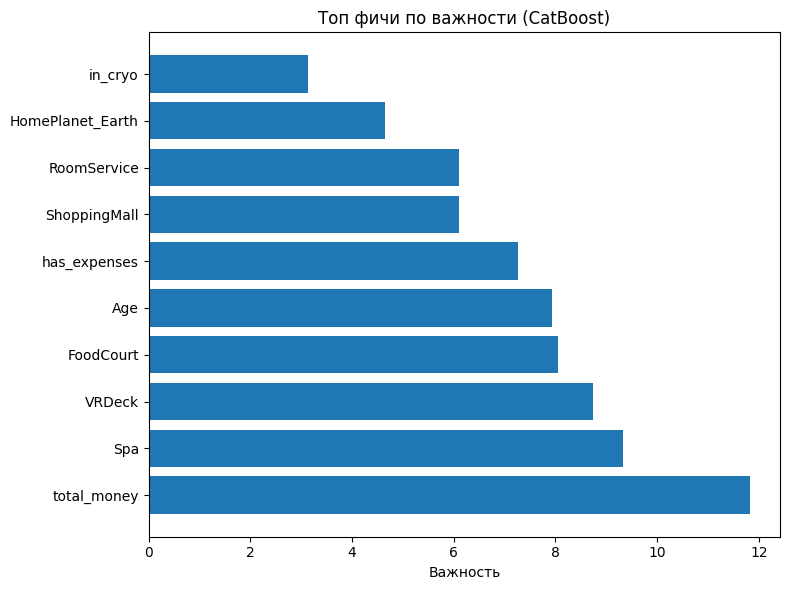

In [96]:
comparison_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
print("\nСравнение моделей:")
print(comparison_df.sort_values('Accuracy', ascending=False))

if 'CatBoost' in results:
    importances = cat_model.get_feature_importance()
    feat_names = X_train.columns
    top_feats = pd.DataFrame({'feature': feat_names, 'importance': importances})
    top_feats = top_feats.nlargest(10, 'importance')  # Топ-10

    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.barh(top_feats['feature'], top_feats['importance'])
    plt.title('Топ фичи по важности (CatBoost)')
    plt.xlabel('Важность')
    plt.tight_layout()
    plt.show()